# Calculating and plotting the demand for different skills across three roles

## Steps:
1. **Clean-up skill column**
2. **Calculate skill count based on `job_title_short`**
3. **Calculate skill percentage**
4. **Plot the results**


### Importing libraries & basic cleaning 

In [83]:
import pandas as pd
import ast

from datasets import load_dataset
import matplotlib.pyplot as plt 
import seaborn as sns

dataset = load_dataset("lukebarousse/data_jobs")
df = dataset["train"].to_pandas()

df["job_posted_date"] = pd.to_datetime(df["job_posted_date"])
df["job_skills"] = df["job_skills"].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x) # job skills coloumn is converted to list

### Calculating based on India and sampling

In [3]:
df_India = df[df["job_country"] == "India"]
df_India.sample(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills
690563,Data Engineer,Software Development Engineer III - Data Engineer,"Bengaluru, Karnataka, India",via LinkedIn,Full-time,False,India,2023-11-08 10:32:34,False,False,India,None,NaN,NaN,Flipkart,"[java, python, nosql, mongodb, mongodb, sql, c...","{'cloud': ['gcp', 'aws'], 'databases': ['mongo..."
150022,Senior Data Engineer,Senior Data Engineer,"Bengaluru, Karnataka, India",via SmartRecruiters Job Search,Full-time,False,India,2023-12-04 08:12:18,True,False,India,None,NaN,NaN,Version 1,"[sql, python, oracle, aws, azure, pyspark, pow...","{'analyst_tools': ['power bi'], 'cloud': ['ora..."
572258,Data Engineer,Data Engineer,"Bengaluru, Karnataka, India",via BeBee India,Full-time,False,India,2023-03-09 09:17:52,True,False,India,None,NaN,NaN,Alstom,"[python, excel, qlik]","{'analyst_tools': ['excel', 'qlik'], 'programm..."


In [27]:
df_skills = df_India.explode("job_skills")
df_skills[["job_title_short", "job_skills"]].head(5)

,job_title_short,job_skills
16,Data Engineer,powershell
16,Data Engineer,python
16,Data Engineer,sql
16,Data Engineer,mysql
16,Data Engineer,sql server


### Grouping based on job_skills and job_title_short and calculating their size

In [38]:
df_skills_count = df_skills.groupby(["job_skills", "job_title_short"]).size()
df_skills_count = df_skills_count.reset_index(name = "skill_count") # converting to dataframe
df_skills_count.sort_values(by="skill_count", ascending=False, inplace=True) # sorting them in a descending manner
df_skills_count

,job_skills,job_title_short,skill_count
1374,sql,Data Engineer,12993
1088,python,Data Engineer,11568
1089,python,Data Scientist,9248
1327,spark,Data Engineer,7157
103,aws,Data Engineer,6993
...,...,...,...
34,angular.js,Data Scientist,1
49,arch,Business Analyst,1
787,mlpack,Data Engineer,1
1679,yarn,Senior Data Scientist,1


### Calculating and plotting top three roles

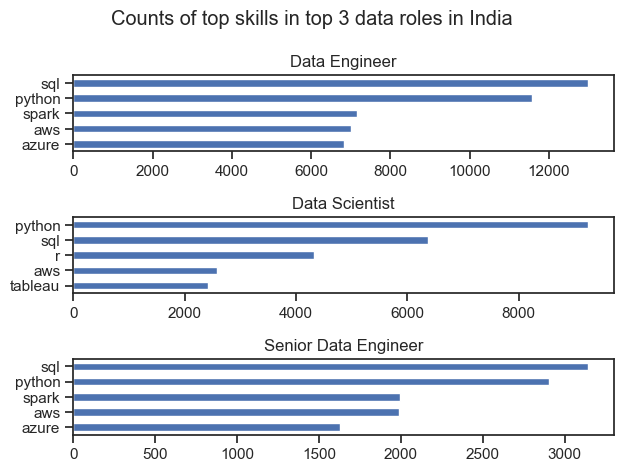

In [104]:
job_titles = df_India["job_title"].value_counts().head(3).index.to_list()
job_titles

fig, ax = plt.subplots(len(job_titles), 1)

for i, job_title in enumerate(job_titles):
    # print(i, job_title)
    df_plot = df_skills_count[df_skills_count["job_title_short"] == job_title].head(5)
    df_plot.plot(kind="barh", x="job_skills", y="skill_count", ax=ax[i], title=job_title, legend=False)
    ax[i].invert_yaxis()
    ax[i].set_ylabel("")
    
fig.suptitle("Counts of top skills in top 3 data roles in India")
plt.tight_layout()
plt.show()

### Adding percentage representation

In [108]:
df_job_title_count = df_India["job_title_short"].value_counts().reset_index(name="jobs_total")
df_job_title_count

,job_title_short,jobs_total
0,Data Engineer,19062
1,Data Scientist,13279
2,Data Analyst,6121
3,Senior Data Engineer,4353
4,Senior Data Scientist,2486
5,Business Analyst,1887
6,Software Engineer,1795
7,Senior Data Analyst,1083
8,Machine Learning Engineer,671
9,Cloud Engineer,351


### Merging both dataframes

In [109]:
df_skill_perc = pd.merge(df_skills_count, df_job_title_count, how="left", on="job_title_short")
df_skill_perc["percentage"] = df_skill_perc["skill_count"] / df_skill_perc["jobs_total"] * 100
df_skill_perc

,job_skills,job_title_short,skill_count,jobs_total,percentage
0,sql,Data Engineer,12993,19062,68.161788
1,python,Data Engineer,11568,19062,60.686182
2,python,Data Scientist,9248,13279,69.643798
3,spark,Data Engineer,7157,19062,37.545903
4,aws,Data Engineer,6993,19062,36.685552
...,...,...,...,...,...
1684,angular.js,Data Scientist,1,13279,0.007531
1685,arch,Business Analyst,1,1887,0.052994
1686,mlpack,Data Engineer,1,19062,0.005246
1687,yarn,Senior Data Scientist,1,2486,0.040225


### Plotting the percentage dataframe with Seaborn

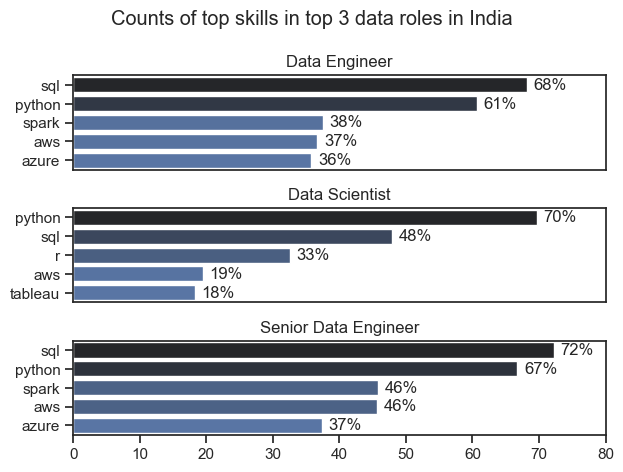

In [115]:
job_titles = df_India["job_title"].value_counts().head(3).index.to_list()
job_titles

sns.set_theme(style="ticks")

fig, ax = plt.subplots(len(job_titles), 1)

for i, job_title in enumerate(job_titles):
    df_plot = df_skill_perc[df_skill_perc["job_title_short"] == job_title].head(5)
    # df_plot.plot(kind="barh", x="job_skills", y="percentage", ax=ax[i], title=job_title, legend=False)
    sns.barplot(data=df_plot, x="percentage", y="job_skills", ax=ax[i], hue="skill_count", palette="dark:b_r", legend=False)
    ax[i].set_title(job_title)
    ax[i].set_ylabel("")
    ax[i].set_xlabel("")
    ax[i].set_xlim(0, 80)
    
    for n, v in enumerate(df_plot['percentage']):
        # print(n, v)
        ax[i].text(v + 1, n, f'{v:.0f}%', va='center') # v + 1 for space
        
    if i != len(job_titles) - 1:
        ax[i].set_xticks([])

    
fig.suptitle("Counts of top skills in top 3 data roles in India")
plt.tight_layout()
plt.show()